# Import and Cleaning

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime
from functions import remove_high_corr, scale_variables, best_params_grid,\
    calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label,get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split,\
    cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,\
    make_scorer, balanced_accuracy_score, f1_score, matthews_corrcoef

# Load data

In [2]:
data = pd.read_csv("/home/gustavo/github/mestrado/reworks/models/oral_vs_non_oral/data/fda_mordred2d_preprocessed.csv")
data

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,SRW05
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486111,0.500000,0.000000
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486111,0.500000,0.000000
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277778,0.500000,0.000000
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,...,0.042311,0.024173,0.019347,0.015274,0.011238,0.009539,0.007525,0.500665,1.000000,3.433987
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.043700,0.023278,0.019448,0.015039,0.010785,0.010123,0.008143,0.517615,0.846154,0.000000
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,...,0.040465,0.021715,0.018162,0.016393,0.010481,0.009014,0.008991,0.562713,0.944444,0.000000
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.041997,0.023356,0.019553,0.014516,0.010891,0.010090,0.008119,0.490360,0.950000,0.000000


# Separating X, Y, test and train

In [3]:
Y = data['oral']
# Transforming oral into categories
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: oral, dtype: float64

In [4]:
X = data.iloc[:, 14:]
X.head()

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,nSpiro,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,SRW05
0,2.449490,0.0,3.0,1.732051,0.866025,1.931852,5.583629,0.803548,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0,0.0
1,3.047207,0.0,0.0,1.847759,1.045250,2.130986,8.629874,1.462083,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486111,0.5,0.0
2,3.047207,0.0,0.0,1.847759,1.045250,2.130986,8.629874,1.462083,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486111,0.5,0.0
3,2.121320,0.0,1.0,1.618034,1.118034,1.946498,5.891993,0.857304,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277778,0.5,0.0
4,2.449490,0.0,0.0,1.732051,0.866025,1.931852,5.583629,0.803548,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0,0.0


In [5]:
np.random.seed(6752)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Scaling datasets

In [6]:
# Train
x_train_scaled = scale_variables(x_train)

# Adding a constant to be the intercept term
x_train_scaled = sm.add_constant(x_train_scaled)
print(x_train_scaled.shape)
x_train_scaled.head()

(1421, 558)


,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,SRW05
0,1.0,-1.167128,-0.431491,-0.706487,-1.938811,0.006298,-1.221960,-0.027007,-1.117373,-0.450139,...,-1.002327,-0.522451,-1.149708,-0.369462,0.075276,1.554729,-1.244187,-1.463320,-0.885550,-0.986243
1,1.0,0.254571,3.749070,-0.706487,-1.349684,-1.043111,0.622759,-0.027001,0.144099,-0.450139,...,-0.181550,-0.373325,-0.307961,-0.242193,-0.120509,0.547573,-0.020373,-0.003890,-0.021712,-0.986243
2,1.0,0.302891,-0.431491,0.463581,0.304355,1.147695,-0.602591,-0.026680,2.035130,1.500920,...,-1.142030,-1.056057,-0.974988,-0.293990,-0.269694,-0.417675,-0.429655,-1.644196,-0.117694,0.736067
3,1.0,-0.439773,-0.431491,-0.706487,0.517775,1.457070,0.050871,-0.027006,-0.584871,0.450350,...,-0.188156,-0.636067,-0.188120,-0.486877,-1.868111,-1.539289,-1.244187,-1.483572,-1.317470,1.681065
4,1.0,0.469084,-0.431491,0.463581,-0.824985,1.278065,0.390547,-0.026994,0.495955,1.350839,...,-1.464394,-0.617721,-0.354252,-1.087914,-0.912301,-0.363562,0.231779,-1.769361,0.842126,-0.986243


In [7]:
# Teset
x_test_scaled = scale_variables(x_test)
x_test_scaled = sm.add_constant(x_test_scaled)
x_test_scaled.head()

,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,SRW05
0,1.0,0.900250,-0.357690,0.399126,-0.153068,0.030407,2.110986,-0.046417,0.210337,1.314817,...,-0.107990,-0.295013,0.489457,-0.024135,0.045225,0.290654,0.492690,0.009925,-0.126568,-0.979296
1,1.0,-0.296212,-0.357690,0.399126,0.680391,-1.006234,-0.249552,-0.046417,-0.053449,-0.618350,...,1.517127,1.551419,0.590763,-0.016561,0.008934,1.094160,1.055643,1.171308,-0.585201,0.713246
2,1.0,-0.329124,-0.357690,-0.669719,0.209601,0.190969,0.052628,-0.046418,-0.389954,0.422586,...,-0.122308,-0.275216,0.512981,0.675958,-0.662915,-1.514256,-1.207754,-0.871606,-2.511458,-0.979296
3,1.0,-0.213870,-0.357690,-0.669719,1.196502,0.923579,0.011793,-0.046418,-0.264640,-1.361876,...,0.557282,0.439020,1.224219,0.936733,0.760814,2.012911,0.439729,0.794926,-0.585201,0.713246
4,1.0,-1.219090,1.390198,-0.669719,-1.139798,-1.644375,-1.500380,-0.046418,-1.319081,-0.469645,...,0.421275,5.211865,-2.659319,-2.375816,-1.822379,-1.514256,-1.207754,0.745270,0.790697,-0.979296


In [8]:
# creating a dataframe to store final results from each model
final_results =pd.DataFrame(
    columns=[
        'model_name',
        'cv_test_auc',
        'training_mis_rate',
        'test_mis_rate',
        'training_auc',
        'test_auc',
        'balanced_acc_test',
        'mcc_train',
        'mcc_test'
    ]
)

# Logistic Regression

## CV

In [9]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=500),
        'params': {}
    }
}

In [10]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train_scaled, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 18:49


Finished Grid Search for Logistic Regression: 18:49
Tempo de execução:  0.1 minutos


## Fitting Logistic Regression


In [11]:
lr_params = gs_result_lr.iloc[0,2]
print(lr_params)

logistic = LogisticRegression(**lr_params, max_iter=500).fit(x_train_scaled, y_train)

{}


## Get Training Error and AUC

In [12]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=logistic,
    x=x_train_scaled,
    y_true=y_train,
)

Training Misclassification Rate: 0.1626
Training AUC: 0.8147


## Make predictions

In [13]:
y_predict_lr_label = logistic.predict(x_test_scaled)
y_predict_lr_prob = logistic.predict_proba(x_test_scaled)[:,1]

## Test error and ROC

In [14]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_lr_label
)

Misclassification rate: 0.3122


Text(0.5, 1.0, 'Confusion Matrix: Logit Classification\n Oral vs Non Oral, Mordred')

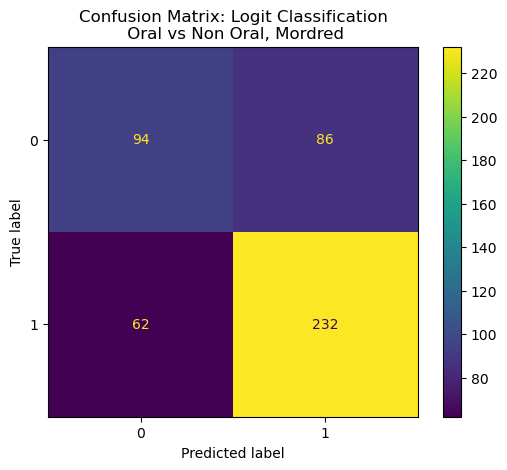

In [15]:
disp.plot()
plt.title(f"Confusion Matrix: Logit Classification\n Oral vs Non Oral, Mordred")

## ROC


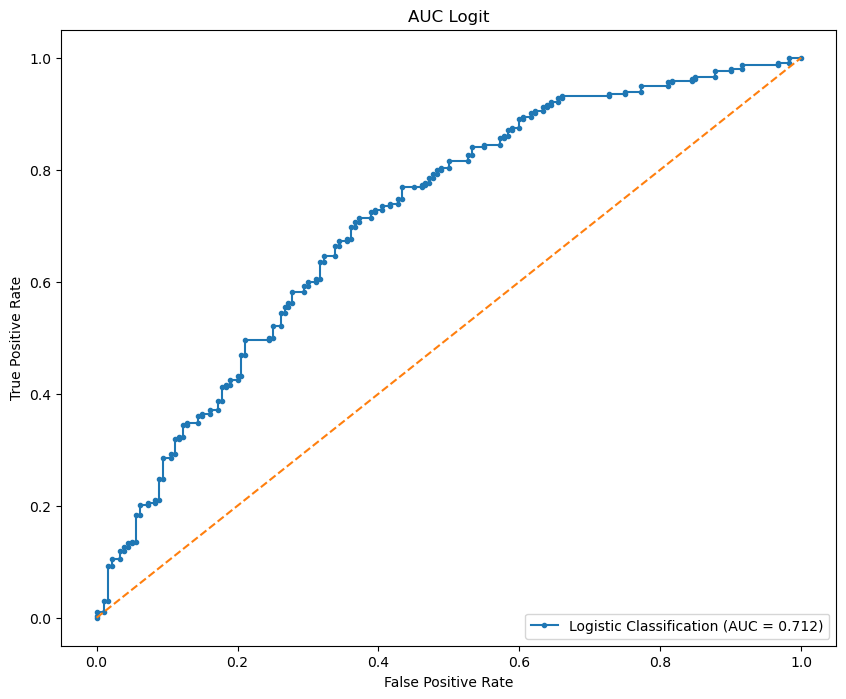

In [16]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name='Logistic Classification',
    title=f"AUC Logit",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/logistic_mordred_total.png"
)

## Results

In [17]:
balanced_acc_test_lr = balanced_accuracy_score(y_test, y_predict_lr_label)
mcc_test_lr = matthews_corrcoef(y_test, y_predict_lr_label)
mcc_train_lr = matthews_corrcoef(y_train, logistic.predict(x_train_scaled))

print(f"Balanced ACC test set {balanced_acc_test_lr}\
      MCC train: {mcc_train_lr} and MCC test: {mcc_test_lr}")

final_results.loc[len(final_results.index)] = [
    "Logistic",
    gs_result_lr['best_score'][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr,
    balanced_acc_test_lr,
    mcc_train_lr,
    mcc_test_lr
]
final_results                                
                                

Balanced ACC test set 0.6556689342403628      MCC train: 0.6492808086508609 and MCC test: 0.3215629515964013


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic,0.646537,0.162562,0.312236,0.814728,0.711508,0.655669,0.649281,0.321563


# Decision Tree

## Hyperparameter Fine tuning

In [18]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [3,4,5,],
            'ccp_alpha':[0.001,0.002]
        }
    }
}

In [19]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Decision Tree: 18:49
Finished Grid Search for Decision Tree: 18:50
Tempo de execução:  0.5 minutos


In [20]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.608911,"{'ccp_alpha': 0.001, 'criterion': 'entropy', '..."


## Fitting tree

In [21]:
decision_tree_params = gs_result_dt.iloc[0,2]
print(decision_tree_params)
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train_scaled, y_train)

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 4}


## Training Error and AUC

In [22]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.3089
Training AUC: 0.6058


## Predictions


In [23]:
y_predict_dt_label = decision_tree.predict(x_test_scaled)
y_predict_dt_prob = decision_tree.predict_proba(x_test_scaled)[:,1]

## Test errors

In [24]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_dt_label
)

Misclassification rate: 0.3565


Text(0.5, 1.0, 'CM Decision Tree \nOral vs Non Oral')

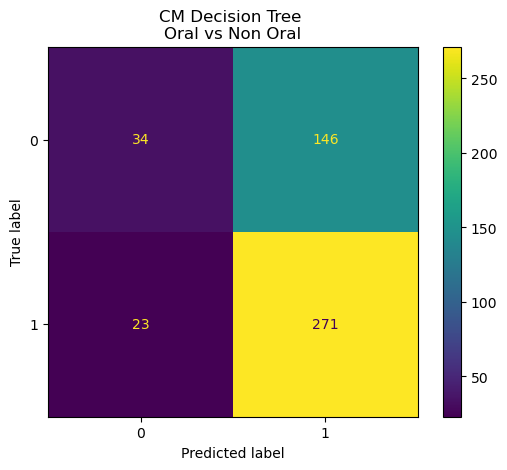

In [25]:
disp.plot()
plt.title(f"CM Decision Tree \nOral vs Non Oral")

## AUC Test set

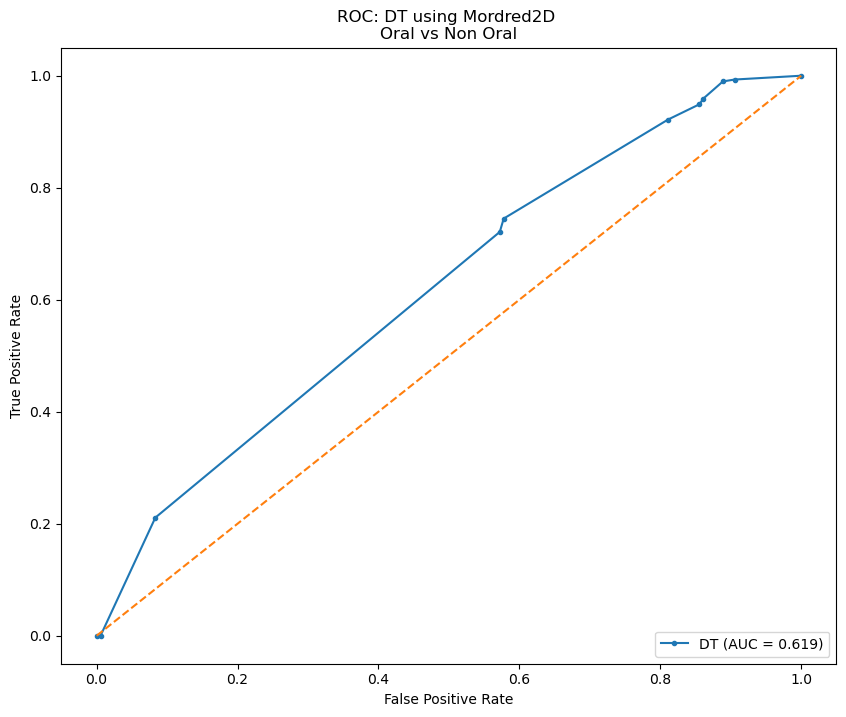

In [26]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name='DT',
    title=f"ROC: DT using Mordred2D \nOral vs Non Oral",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/dt_mordred2d.png"
)

## Feature Importance

<Axes: >

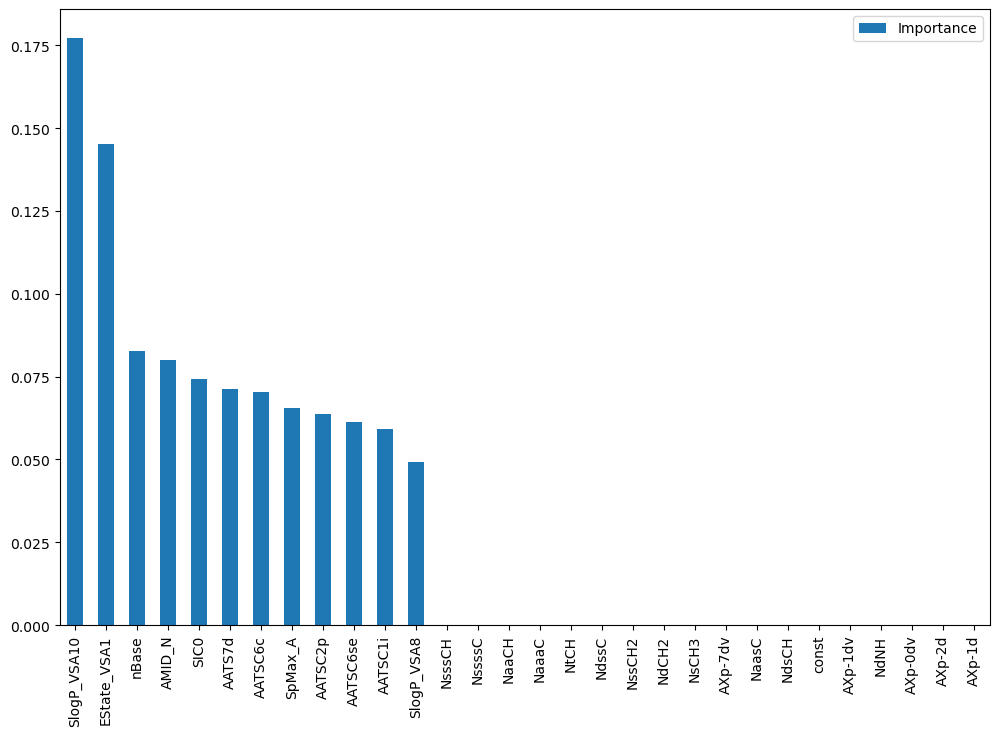

In [27]:
# print the feature importance
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(
    decision_tree.feature_importances_,
    index=x_train_scaled.columns,
    columns=['Importance']
)
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12, 8), ax=ax)

In [28]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by='Importance', ascending=False)
important_features_dt[:30]

,Importance
SlogP_VSA10,0.177129
EState_VSA1,0.145155
nBase,0.082871
AMID_N,0.080028
SIC0,0.074408
AATS7d,0.071261
AATSC6c,0.070243
SpMax_A,0.065667
AATSC2p,0.063578
AATSC6se,0.061351


## Results

In [29]:
balanced_acc_test_dt = balanced_accuracy_score(y_test, y_predict_dt_label)
mcc_train_dt = matthews_corrcoef(y_train, decision_tree.predict(x_train_scaled))
mcc_test_dt = matthews_corrcoef(y_test, y_predict_dt_label)

print(f"Balanced ACC test set:\
      {balanced_acc_test_dt} \n MCC train {mcc_train_dt} MCC test {mcc_test_dt}")

final_results.loc[len(final_results.index)] = [
    'Decision Tree',
    gs_result_dt['best_score'][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt,
    balanced_acc_test_dt,
    mcc_train_dt,
    mcc_test_dt 
]
final_results

Balanced ACC test set:      0.555328798185941 
 MCC train 0.3123440139133909 MCC test 0.16511468295724618


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic,0.646537,0.162562,0.312236,0.814728,0.711508,0.655669,0.649281,0.321563
1,Decision Tree,0.608911,0.308937,0.356540,0.605806,0.619123,0.555329,0.312344,0.165115


# Random Forest and Bagging

Training Misclassification Rate: 0.1281
Training AUC: 0.8323
Misclassification rate: 0.3059


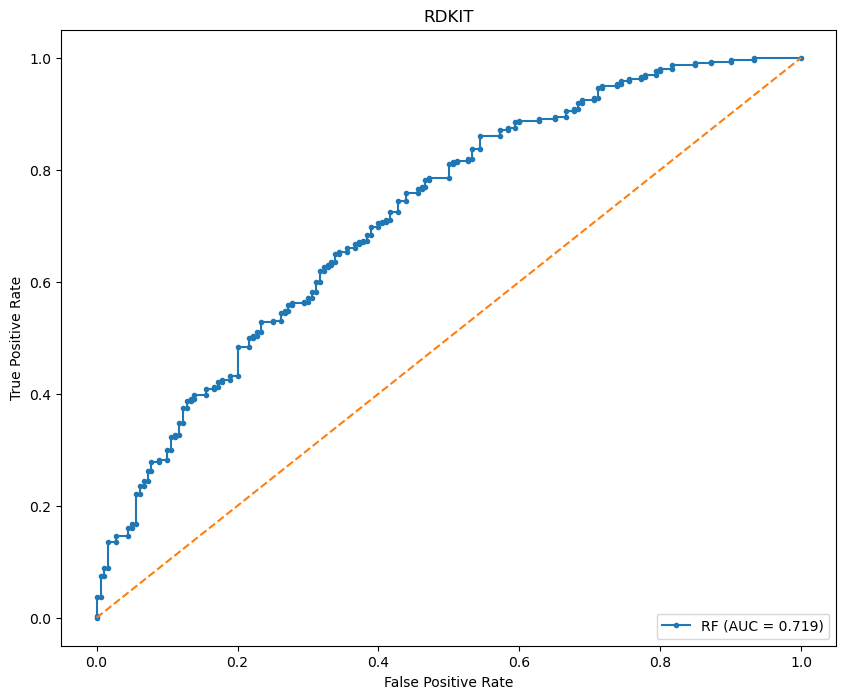

In [30]:
# testing
rf_model_params_test = {'max_depth':8, 'ccp_alpha':0.0008, 'min_samples_split':15}
rf_test = RandomForestClassifier(**rf_model_params_test).fit(x_train_scaled, y_train)

# Make predictions
y_predict_rf_label_test = rf_test.predict(x_test_scaled)
y_predict_rf_prob_test = rf_test.predict_proba(x_test_scaled)[:,1]

mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=rf_test,
    x=x_train_scaled,
    y_true=y_train
)

mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_rf_label_test
)


auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob_test,
    model_name='RF',
    title=f'RDKIT',
    save_path='/home/gustavo/github/mestrado/reworks/imgs/random_forest_test.png'
)


In [31]:
#  hyperparameter finetuning

rf_model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'max_depth': [5,8],
            'max_features': ['sqrt'],
            'ccp_alpha': [0.0008, 0.00010],
            'min_samples_split': [15]
        }
    }
}

In [32]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train_scaled, y_train, rf_model_params)

Starting Grid Search for Random Forest: 18:50
Finished Grid Search for Random Forest: 18:50
Tempo de execução:  0.8 minutos


## Fitting Model


In [33]:
random_forest_params = gs_result_rf.iloc[0,2]
print(random_forest_params)

random_forest = RandomForestClassifier(**random_forest_params).fit(x_train_scaled, y_train)

{'ccp_alpha': 0.0008, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 15}


## Making Predictions

In [34]:
y_predict_rf_label = random_forest.predict(x_test_scaled)
y_predict_rf_prob = random_forest.predict_proba(x_test_scaled)[:,1]

## Get Training Error and AUC

In [35]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.1239
Training AUC: 0.8372


## Test Error

In [36]:
mis_rate_df, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_rf_label,

)

Misclassification rate: 0.2996


Text(0.5, 1.0, 'Confusion Matrix: Random Forest\nOral vs Non Oral, Mordred2D')

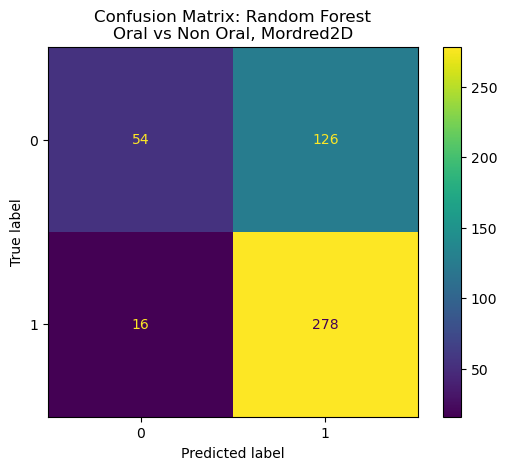

In [37]:
disp.plot()
plt.title(f"Confusion Matrix: Random Forest\nOral vs Non Oral, Mordred2D")

## ROC/AUC

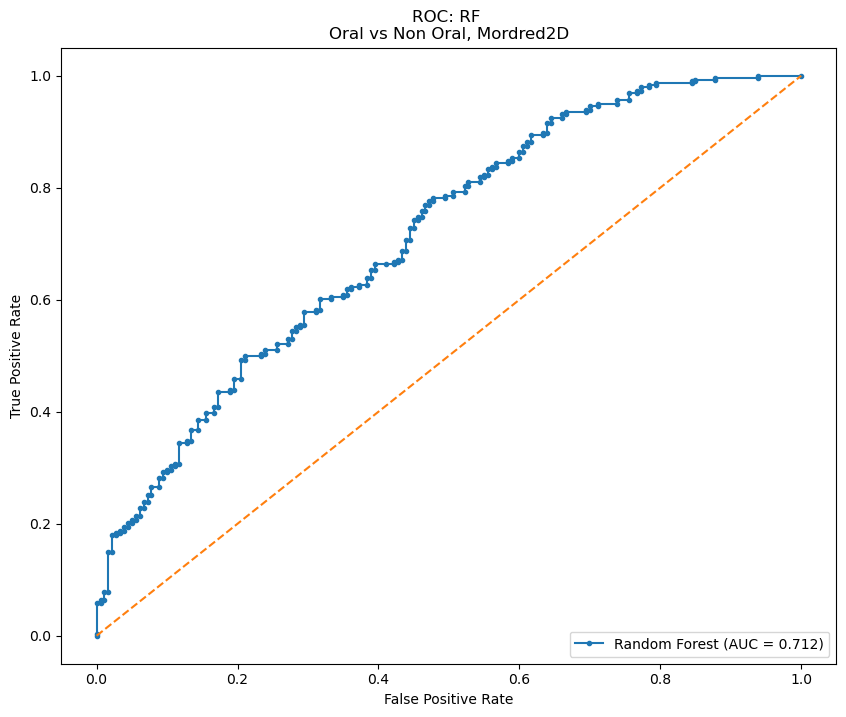

In [38]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name='Random Forest',
    title=f"ROC: RF \nOral vs Non Oral, Mordred2D",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_mordred2d_rf.png"
)

## Feature Importance

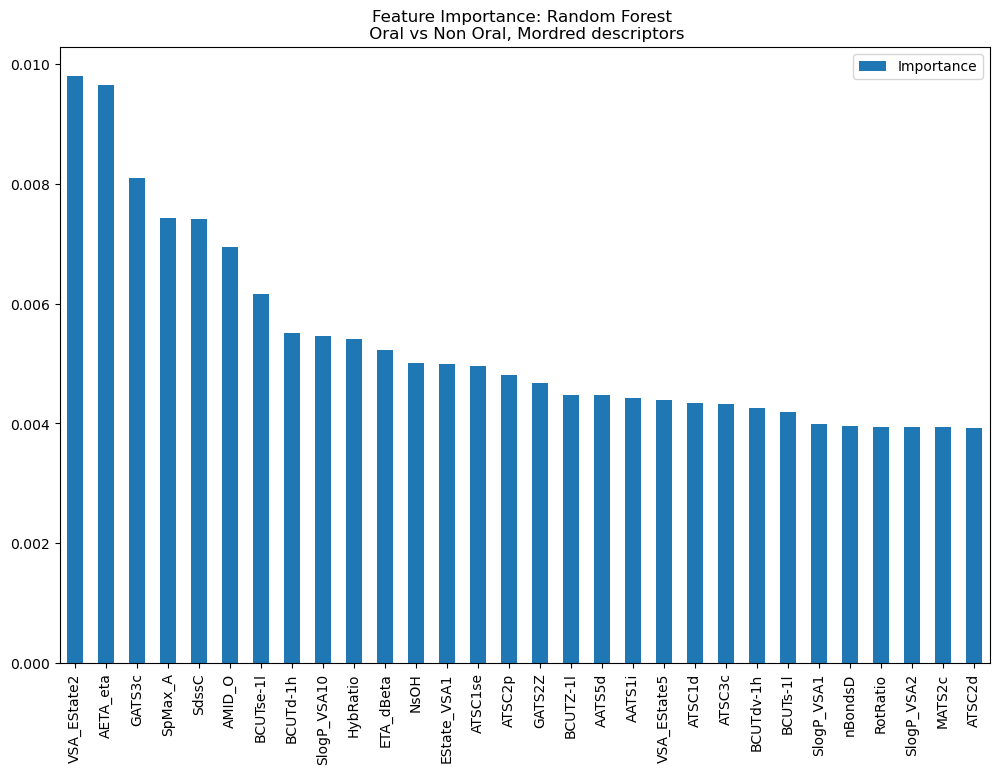

In [39]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(
    random_forest.feature_importances_,
    index=x_train_scaled.columns,
    columns=['Importance']
)
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: Random Forest \n Oral vs Non Oral, Mordred descriptors")
fig.savefig(f"/home/gustavo/github/mestrado/reworks/imgs/feature_importance_rf_mordred.png", dpi=300)

In [40]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by='Importance', ascending=False)
important_features_rf[0:30]

,Importance
VSA_EState2,0.009792
AETA_eta,0.009648
GATS3c,0.008100
SpMax_A,0.007432
SdssC,0.007418
AMID_O,0.006949
BCUTse-1l,0.006167
BCUTd-1h,0.005513
SlogP_VSA10,0.005460
HybRatio,0.005413


## Saving Results

In [41]:
balanced_acc_test_rf = balanced_accuracy_score(y_test, y_predict_rf_label)
mcc_train_rf = matthews_corrcoef(y_train, random_forest.predict(x_train_scaled))
mcc_test_rf = matthews_corrcoef(y_test, y_predict_rf_label)

print(f"Balanced ACC test set {balanced_acc_test_rf}, \
      MCC train set: {mcc_train_rf} MCC test set: {mcc_test_rf}")

final_results.loc[len(final_results.index)] = [
    'Random Forest',
    gs_result_rf['best_score'][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf,
    balanced_acc_test_rf,
    mcc_train_rf,
    mcc_test_rf
]

final_results

Balanced ACC test set 0.6227891156462585,       MCC train set: 0.7479412505578864 MCC test set: 0.3359387348733622


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic,0.646537,0.162562,0.312236,0.814728,0.711508,0.655669,0.649281,0.321563
1,Decision Tree,0.608911,0.308937,0.356540,0.605806,0.619123,0.555329,0.312344,0.165115
2,Random Forest,0.693338,0.123856,0.305907,0.837157,0.711905,0.622789,0.747941,0.335939


# Gradient Boosting

Training Misclassification Rate: 0.1499
Training AUC: 0.8031
Misclassification rate: 0.3165


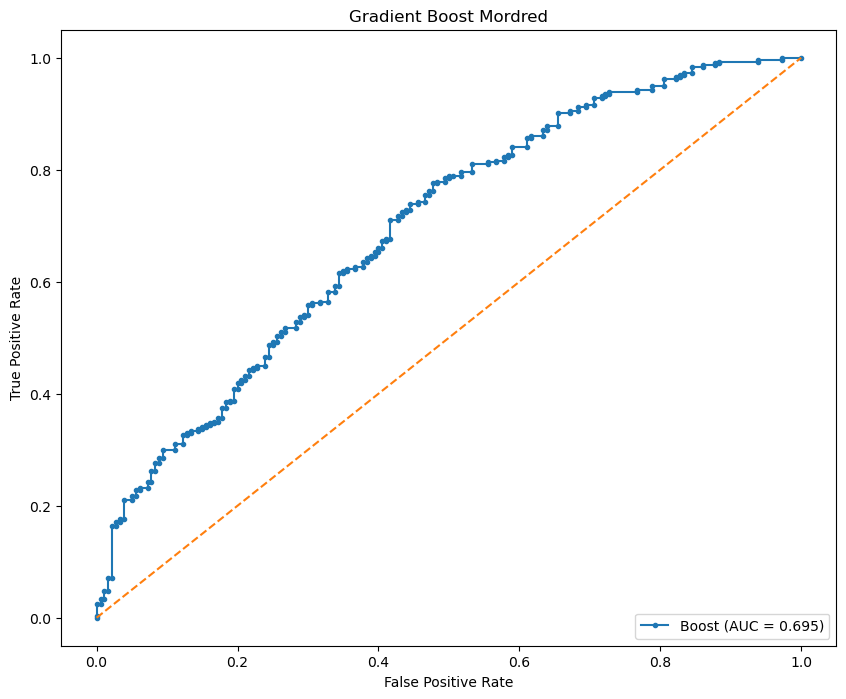

In [42]:
# Testing
gradient_boost_test_params = {
    'max_depth':7,
    'min_samples_split':20,
    'max_features':'sqrt',
    'learning_rate':0.015,
    'subsample': 0.5
}

boost_test = GradientBoostingClassifier(**gradient_boost_test_params).fit(x_train_scaled, y_train)

# makes predictions
y_predict_boost_label_test = boost_test.predict(x_test_scaled)
y_predict_boost_prob_test = boost_test.predict_proba(x_test_scaled)[:,1]

mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boost_test,
    x=x_train_scaled,
    y_true=y_train
)

# test error
mis_rate_boost_test, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label_test
)

auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob_test,
    model_name='Boost',
    title=f"Gradient Boost Mordred",
    save_path='/home/gustavo/github/mestrado/reworks/imgs/boost_test.png'
)

In [43]:
boosting_model_params = {
    'Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.015],
            'max_depth': [7],
            'min_samples_split':[20],
            'subsample':[0.5]
        }
    }
}

In [44]:
gs_result_boost, gs_result_boost_full = best_params_grid(x_train_scaled, y_train, boosting_model_params)

Starting Grid Search for Boosting: 18:51
Finished Grid Search for Boosting: 18:54
Tempo de execução:  3.4 minutos


## Fitting the model

In [45]:
boosting_params = gs_result_boost.iloc[0,2]
print(boosting_params)
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train_scaled, y_train)

{'learning_rate': 0.015, 'max_depth': 7, 'min_samples_split': 20, 'subsample': 0.5}


## Get training error and AUC

In [46]:
mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boosting,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.0971
Training AUC: 0.8725


## Make predictions

In [47]:
y_predict_boost_label = boosting.predict(x_test_scaled)
y_predict_boost_prob = boosting.predict_proba(x_test_scaled)[:,1]

## Test Error

In [48]:
mis_rate_boost, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label
)

Misclassification rate: 0.2975


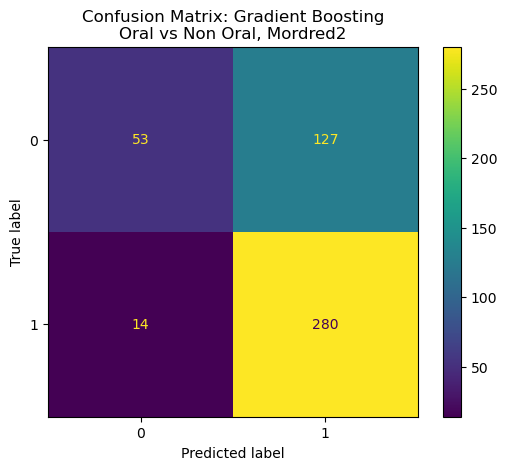

In [49]:
disp.plot()
plt.title(f"Confusion Matrix: Gradient Boosting\nOral vs Non Oral, Mordred2")
plt.show()

## ROC/AUC

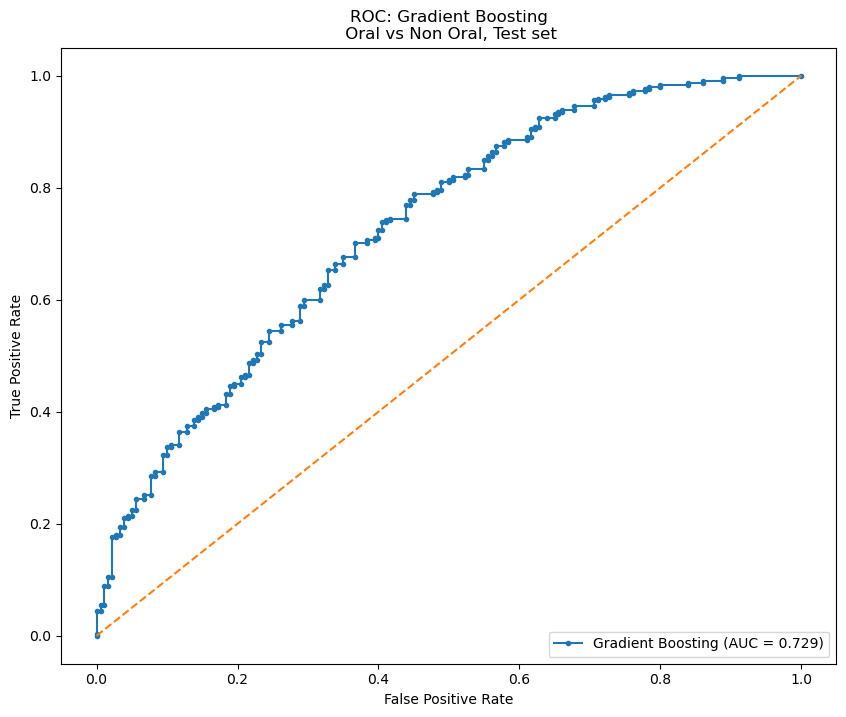

In [50]:
auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob,
    model_name='Gradient Boosting',
    title=f"ROC: Gradient Boosting\n Oral vs Non Oral, Test set",
    save_path='/home/gustavo/github/mestrado/reworks/imgs/roc_auc_mordred2_gb.png'

)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance, Gradient Boosting \n Oral vs Non Oral, Mordred2D')

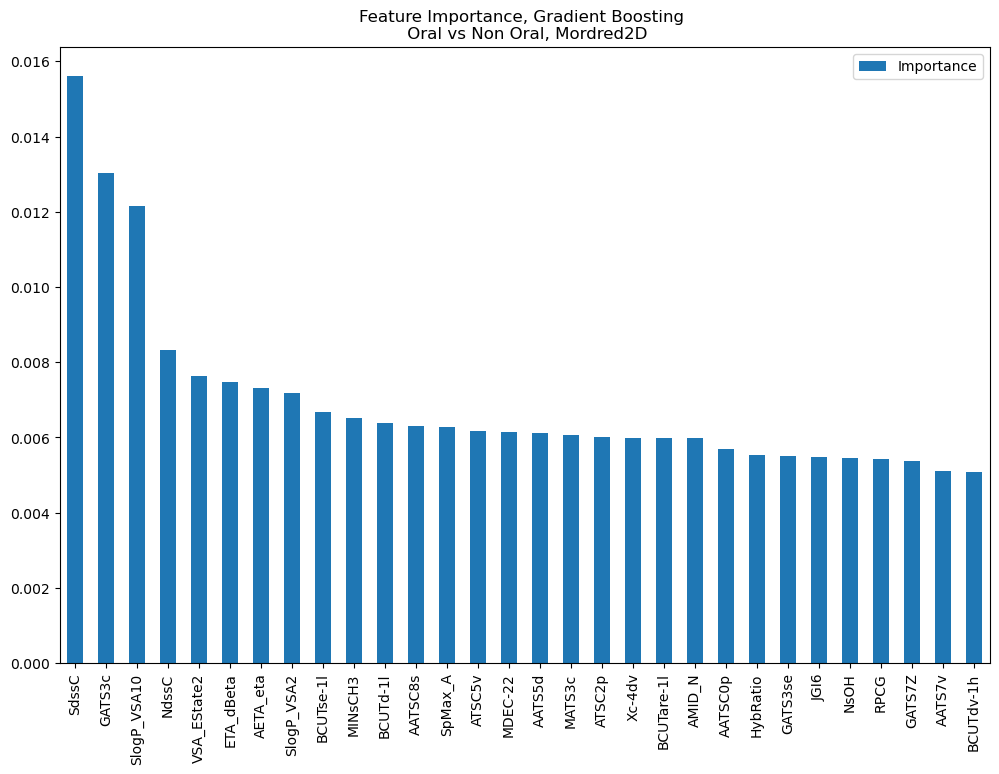

In [51]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(
    boosting.feature_importances_, index=x_train_scaled.columns,
    columns=['Importance']
)
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance, Gradient Boosting \n Oral vs Non Oral, Mordred2D")

In [52]:
important_features_boost = feat_importances[feat_importances.Importance > 0].sort_values(
    by='Importance', ascending=False
)
important_features_boost[0:30]

,Importance
SdssC,0.015599
GATS3c,0.013031
SlogP_VSA10,0.012160
NdssC,0.008336
VSA_EState2,0.007628
ETA_dBeta,0.007481
AETA_eta,0.007303
SlogP_VSA2,0.007185
BCUTse-1l,0.006661
MINsCH3,0.006525


## Saving Results

In [53]:
balanced_acc_test_boost = balanced_accuracy_score(y_test, y_predict_boost_label)
mcc_train_boost = matthews_corrcoef(y_train, boosting.predict(x_train_scaled))
mcc_test_boost = matthews_corrcoef(y_test, y_predict_boost_label)

print(f"Balanced accuracy test {balanced_acc_test_boost}\
      \nMCC train Boost: {mcc_train_boost} MCC test boost: {mcc_test_boost}")

final_results.loc[len(final_results.index)] = [
    'Gradient Boosting',
    gs_result_boost['best_score'][0],
    mis_rate_boost_train,
    mis_rate_boost,
    auc_boost_train,
    auc_boost,
    balanced_acc_test_boost,
    mcc_train_boost,
    mcc_test_boost
    
]

final_results

Balanced accuracy test 0.6234126984126984      
MCC train Boost: 0.8010242097023273 MCC test boost: 0.3438469336101484


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic,0.646537,0.162562,0.312236,0.814728,0.711508,0.655669,0.649281,0.321563
1,Decision Tree,0.608911,0.308937,0.356540,0.605806,0.619123,0.555329,0.312344,0.165115
2,Random Forest,0.693338,0.123856,0.305907,0.837157,0.711905,0.622789,0.747941,0.335939
3,Gradient Boosting,0.693779,0.097115,0.297468,0.872473,0.728571,0.623413,0.801024,0.343847


# SVM

## Hyperparameter and Fine Tuning

In [54]:
svm_model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1,1,2],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', 0.0001, 0.001, 0.01, 0.1, 1]
        }
    }
}

In [55]:
gs_results_svm, gs_result_svm_full = best_params_grid(x_train_scaled, y_train, svm_model_params)

Starting Grid Search for SVM: 18:54


Finished Grid Search for SVM: 18:58
Tempo de execução:  3.9 minutos


## Fitting the model

In [56]:
svm_params = gs_results_svm.iloc[0,2]
print(svm_params)
svm = SVC(**svm_params, probability=True).fit(x_train_scaled, y_train)

{'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}


## Get Train Error and AUC

In [57]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, x=x_train_scaled, y_true=y_train
)

Training Misclassification Rate: 0.1239
Training AUC: 0.8444


## Make prediction

In [58]:
y_predict_svm_label = svm.predict(x_test_scaled)
y_predict_svm_prob = svm.predict_proba(x_test_scaled)[:,1]

## Test error

In [59]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_svm_label
)

Misclassification rate: 0.2996


Text(0.5, 1.0, 'CM: SVM \n Oral vs Non oral, Mordred2')

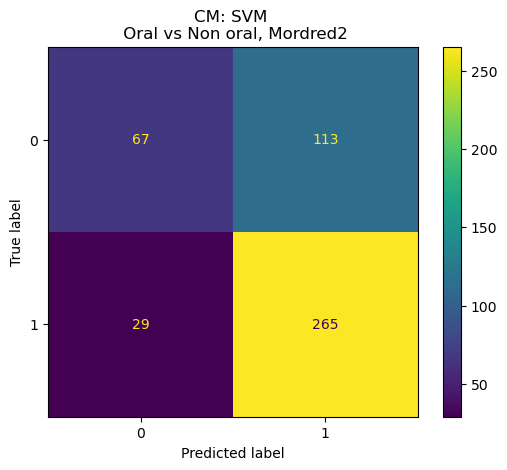

In [60]:
disp.plot()
plt.title(f"CM: SVM \n Oral vs Non oral, Mordred2")

## ROC/AUC

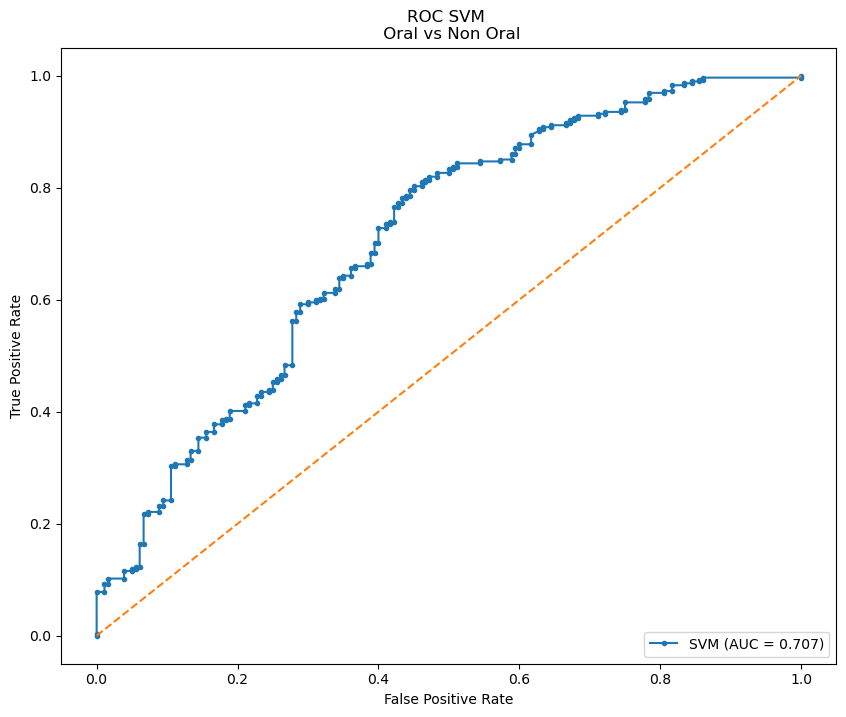

In [61]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name='SVM',
    title=f"ROC SVM \n Oral vs Non Oral",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_mordred_svm.png"
)

## Saving Results

In [62]:
balanced_acc_test_svm = balanced_accuracy_score(y_test, y_predict_svm_label)
mcc_train_svm = matthews_corrcoef(y_train, svm.predict(x_train_scaled))
mcc_test_svm = matthews_corrcoef(y_test, y_predict_svm_label)

print(f"Balanced ACC test set {balanced_acc_test_svm}, \
      \nMCC train set: {mcc_train_svm} MCC test set: {mcc_test_svm} ")

final_results.loc[len(final_results.index)] = [
    "SVM",
    gs_results_svm['best_score'][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm,
    balanced_acc_test_svm,
    mcc_train_svm,
    mcc_test_svm
]

Balanced ACC test set 0.6367913832199547,       
MCC train set: 0.7395942870971278 MCC test set: 0.33038257831212314 


In [63]:
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic,0.646537,0.162562,0.312236,0.814728,0.711508,0.655669,0.649281,0.321563
1,Decision Tree,0.608911,0.308937,0.356540,0.605806,0.619123,0.555329,0.312344,0.165115
2,Random Forest,0.693338,0.123856,0.305907,0.837157,0.711905,0.622789,0.747941,0.335939
3,Gradient Boosting,0.693779,0.097115,0.297468,0.872473,0.728571,0.623413,0.801024,0.343847
4,SVM,0.688256,0.123856,0.299578,0.844420,0.707086,0.636791,0.739594,0.330383
